In [1]:
from src.training.model import TransformerClassifier
from src.utils import load_config
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

# Load data

In [3]:
input_dataset = f"../../output_data/{env}/supervised_dataset.parquet"
# input_new_class = f"../../output_reports/{env}/clustering/temp_new_class.parquet"
input_true_new_class = f"../../output_data/{env}/supervised_dataset_phase2.parquet"

In [4]:
known_classes = pd.read_parquet(input_dataset)
# new_class = pd.read_parquet(input_new_class)
true_new_class = pd.read_parquet(input_true_new_class)

In [5]:
features = training_config.training[model_type].features
target = training_config.training[model_type].target

In [6]:
known_classes = known_classes[[features, target]]
# new_class = new_class[[features, target]]
true_new_class = true_new_class[[features, target]]

In [7]:
num_labels = known_classes[target].nunique()

# Split data

In [8]:
X = known_classes

In [9]:
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(
    # X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].features],
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=X[training_config.training[model_type].target],
)
original_X_test, original_X_cp, original_y_test, original_y_cp = train_test_split(
    original_X_test,
    original_y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=original_y_test,
)

# Upsample the minority class for original data

In [10]:
# Upsample the minority class
X_upsampled = original_X_train.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = original_y_train

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
original_X_train = df_upsampled[training_config.training[model_type].features]
original_y_train = df_upsampled[training_config.training[model_type].target]
df_original_train = pd.concat([original_X_train, original_y_train], axis=1)

# Split true new class

In [12]:
X_train_new_class, X_test_new_class, y_train_new_class, y_test_new_class = (
    train_test_split(
        true_new_class[features],
        true_new_class[target],
        test_size=0.2,
        random_state=42,
        stratify=true_new_class[target],
    )
)
new_class = pd.concat([X_train_new_class, y_train_new_class], axis=1)

# Concatenate the original and new class

In [13]:
df_train = pd.concat(
    [
        df_original_train.sample(
            frac=0.1, random_state=training_config.training.random_state
        ),
        new_class,
    ]
)
X = df_train[features]
y = df_train[target]

In [14]:
df_train[target].value_counts()

label
2    311
1     64
0     53
Name: count, dtype: int64

In [15]:
X.shape, y.shape

((428,), (428,))

# Split the data into training and validation sets

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((342,), (342,), (86,), (86,))

In [18]:
y_train.value_counts()

label
2    249
1     51
0     42
Name: count, dtype: int64

# Prepare test set

In [24]:
X_test = pd.concat([original_X_test, X_test_new_class])
y_test = pd.concat([original_y_test, y_test_new_class])

# Load and train model

In [19]:
new_num_labels = len(y_train.unique())

In [20]:
import importlib
from src.training import model  # Import the module

importlib.reload(model)  # Reload the module

clf = model.TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/trained_model",
)

In [21]:
clf_incremented = clf.incremental_fit(
    X_train,
    y_train,
    new_num_labels,
    eval_X=X_val,
    eval_y=y_val,
    freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    epochs=100,
)

Expanding classifier from 2 to 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../../output_models/prod/trained_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.649300,0.591993
2,0.452500,0.544420
3,0.455000,0.512363
4,0.428300,0.497991
5,0.409800,0.475578
6,0.404600,0.477899
7,0.451600,0.452373
8,0.404100,0.458160
9,0.447200,0.440314
10,0.368300,0.431959


In [26]:
# Save the model
clf_incremented.save_model(f"../../output_models/{env}/incremented_trained_model")

Model and tokenizer saved to ../../output_models/prod/incremented_trained_model.


In [31]:
clf_incremented = model.TransformerClassifier(
    model_name=None,
    num_labels=new_num_labels,
    local_model_path="../../output_models/prod/incremented_trained_model",
)

In [25]:
# Evaluate on test set

from sklearn.metrics import classification_report

y_pred = clf_incremented.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.32      0.47        97
           1       0.85      0.73      0.78        77
           2       0.50      0.96      0.66        78

    accuracy                           0.64       252
   macro avg       0.74      0.67      0.64       252
weighted avg       0.75      0.64      0.62       252



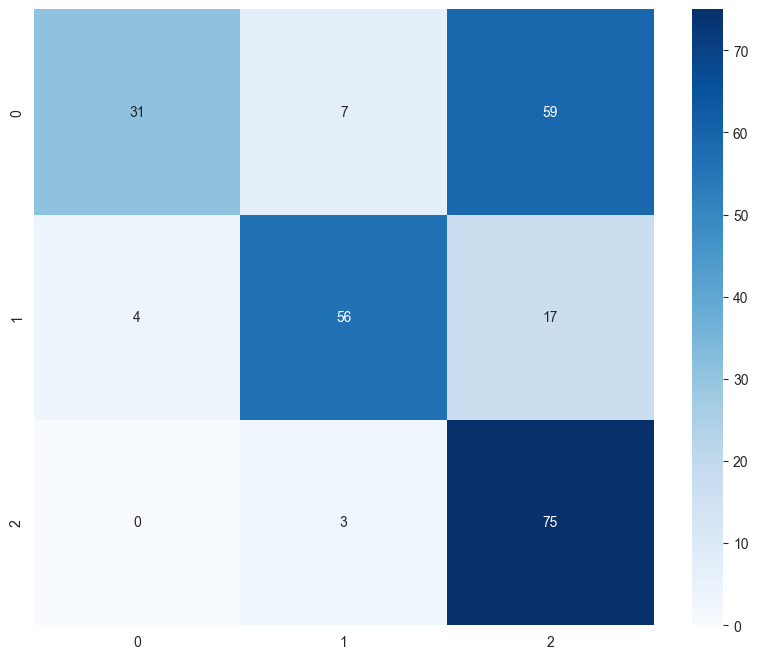

In [26]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [16]:
teste = ["bert.embeddings"] + [f"bert.encoder.layer.{i}" for i in range(9)]

In [17]:
teste

['bert.embeddings',
 'bert.encoder.layer.0',
 'bert.encoder.layer.1',
 'bert.encoder.layer.2',
 'bert.encoder.layer.3',
 'bert.encoder.layer.4',
 'bert.encoder.layer.5',
 'bert.encoder.layer.6',
 'bert.encoder.layer.7',
 'bert.encoder.layer.8']

In [1]:
from src.training.model import TransformerClassifier

num_labels = 10

clf = TransformerClassifier(
    model_name="dtorber/bert-base-spanish-wwm-cased_K4",
    num_labels=num_labels,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dtorber/bert-base-spanish-wwm-cased_K4 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
clf.model.classifier.weight.dtype

torch.float32

In [3]:
clf.model.classifier.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)